# CircularRestricted.py

The CircularRestricted package is a Python utility for modeling the orbital motion of a satellite in multi-body gravipotential regimes, such as the Earth-Moon system, or the Earth-Sun system. Where possible, math operations are accelerated by pre-compiling in C using Numba. 

## Circular Restricted Three-Body Problem

The most basic multi-body problem is the CR3BP problem. Under this formulation, the satellite's motion is expressed relative to a common barycenter shared by two massive bodies. These bodies are assumed to have perfectly circular orbits about their common barycenter, such that their orbits share a constant angular rate. By choosing a rotating reference frame based on this constant angular rate whose origin is fixed at the barycenter, the more-massive (primary) body can be fixed on the negative *X* axis and the less-massive (secondary) body is fixed on the postive *X* axis. The positive *Y* direction is defined as the direction of the secondary body's tangential orbit velocity, and the *Z* axis completes the right-handed axis system (and is parallel to the secondary body's angular momentum vector). In this formulation, there are 5 equilibrium points (called Lagrange points) in the gravipotential field. Three lie on the *X* axis, and are unstable equilibria (saddle points); the remaining two are vertices of two equilateral triangles where the other two vertices are the center of the primary and secondary bodies, and are stable equilibria. 

## Example 1: Instantiating a scenario

First, import the `CR3BP` class from CircularRestricted.py. You will also need to provide input values as AstroPy units. The Poliastro package also makes it easy to access constants of certain celestial bodies, so we will import those as well.

In [17]:
from CircularRestricted import CR3BP
from astropy import units as u
from poliastro.bodies import Sun, Moon, Earth
import numpy as np

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = 20, 10 # For iPython notebook plots

To instantiate a `CR3BP` scenario, provide the primary body's mass, secondary body's mass, and the (assumed constant) distance between them as AstroPy units of kg, kg, and km respectively.

In [18]:
EM = CR3BP(Earth.mass, Moon.mass, 384400*u.km)

Let's explore some of the attributes of our object using the `CR3BP.summary()` method. This prints several attributes and plots a sketch of the system with Lagrange points shown. For differently sized and spaced bodies, the positions of the collinear Lagrange points can shift considerably.

CR3BP constant (μ):  0.012150584709882378
  -  Note: μ is defined as m2 / (m1 + m2)
Primary body mass (m1): 5.972168e+24 kg
Secondary body mass (m2): 7.345789e+22 kg
Primary-Secondary distance:  384400.0 km
L1 position (non-dimensional): 0.836915
L2 position (non-dimensional): 1.155682


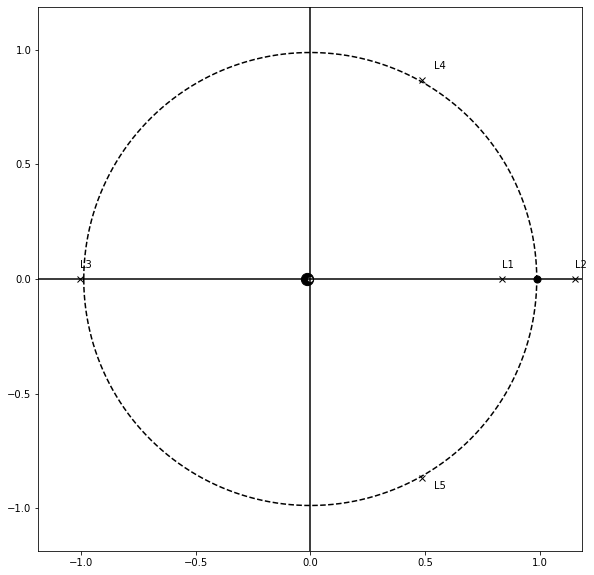

In [19]:
EM_fig, EM_ax = EM.summary()

### A lengthy note on non-dimensional units

In the summary above, the L1 and L2 positions are given in non-dimensional units. What are these? Quantities in these scenarios are often normalized to non-dimensional units to avoid performing computations with very large or very small numbers. This helps preserve the validity of numerical methods that are used to propagate these trajectories. Numerical methods are required because there is no closed-form analytical solution for the motion of an object in these dynamics. 

In order to navigate the conversion between conventional and non-dimensional units, you can use the `CR3BP.convert()` method, as shown below:

In [ ]:
L1_nondim = EM.xL['L1']
print('L1 position (non-dimensional): ',EM.xL['L1'])

L1_km = EM.convert(L1_nondim, to='km')
print('L1 position (in kilometers): ', L1_km)

L1_m = EM.convert(L1_nondim, to='m')
print('L1 position (in meters): ', L1_m)

L1_pc = EM.convert(L1_nondim, to='parsec')
print('L1 position (in parsecs): ', L1_pc)

In this scenario, the following quantities are converted to nondimensional values:
- Length (normalized by the primary-secondary distance)
- Mass (normalized by the sum of the primary & secondary masses)
- Time (normalized by the period of the primary-secondary orbit)
- Any combination of these units (e.g. Velocity, Acceleration)

The `CR3BP.convert()` method will also know how to convert values into nondimensional units if they are passed as instances of AstroPy's `Quantity`. For example:

In [20]:
qty1 = 77*u.km/u.hr
print('In non-dimensional units, ',qty1, ' is ', EM.convert(qty1))

qty2 = 209809*u.mm/(u.d**2)
print('In non-dimensional units, ',qty2, ' is ', EM.convert(qty2))

qty3 = 1*u.yr
print('In non-dimensional units, ',qty3, ' is ', EM.convert(qty3))


In non-dimensional units,  77.0 km / h  is  0.020876439073891046
In non-dimensional units,  209809.0 mm / d2  is  1.0292394020069435e-05
In non-dimensional units,  1.0 yr  is  84.11092132325106


It is also helpful to know how to use AstroPy to convert units using the `Quantity.to()` method, which is very handy:

In [21]:
print( (1*u.yr).to('day') )

365.25 d


Finally, arrays or lists of quantities can be converted all at once by also providing the `to` input as an array or list of the same length. Since it is anticipated that state vectors will be frequently converted between dimensional and non-dimensional quantities, one can use the `state_vec` flag to avoid having to type out 6-element arrays every time:

In [50]:
some_qtys = [19*u.mm, 4*u.d]
print('In non-dimensional units,\n ',some_qtys)
nondim_qtys = EM.convert(some_qtys)
print('are equivalent to:\n ',nondim_qtys)

new_qtys = EM.convert(nondim_qtys, to=['cm','hr'])
print('\nThe non-dimensional values \n',nondim_qtys,
      '\nare equivalent to: \n',new_qtys)

nondim_X = [  0.3,   0.1,    0.2, 
            0.001, 0.002, -0.001]
print('\nThe non-dimensional state vector \n', nondim_X)
dim_X = EM.convert(nondim_X, to=['km','s'], state_vec=True)
print('is equivalent to: \n', dim_X)

dim_X = [384400*u.km, 0*u.km, 0*u.km, 
         0*u.km/u.s, 0*u.km/u.s, 0*u.km/u.s]
print('\nThe dimensional state vector \n', dim_X)
nondim_X = EM.convert(dim_X, state_vec=True)
print('is equivalent to: \n', nondim_X)

In non-dimensional units,
  [<Quantity 19. mm>, <Quantity 4. d>]
are equivalent to:
  [<Quantity 4.94276795e-11>, <Quantity 0.92113261>]

The non-dimensional values 
 [<Quantity 4.94276795e-11>, <Quantity 0.92113261>] 
are equivalent to: 
 [<Quantity 1.9 cm>, <Quantity 96. h>]

The non-dimensional state vector 
 [0.3, 0.1, 0.2, 0.001, 0.002, -0.001]
is equivalent to: 
 [<Quantity 115320. km>, <Quantity 38440. km>, <Quantity 76880. km>, <Quantity 0.00102455 km / s>, <Quantity 0.00204909 km / s>, <Quantity -0.00102455 km / s>]

The dimensional state vector 
 [<Quantity 384400. km>, <Quantity 0. km>, <Quantity 0. km>, <Quantity 0. km / s>, <Quantity 0. km / s>, <Quantity 0. km / s>]
is equivalent to: 
 [<Quantity 1.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>]


# Example 2: Propagating a Spacecraft in the Scenario

For this example, we will reuse the scenario from the previous example, and proceed with instantiating a Spacecraft object and a `Propagator` object. A `Spacecraft` object belongs to one scenario. A `Propagator` object belongs to one `Spacecraft`. This is evident upon instantiating these objects and calling their `.summary()` methods:

In [4]:
from CircularRestricted import Spacecraft

sc = Spacecraft(EM)
sc.set_initial_state([0.5, 0, 0, 0, 0, 0])
sc.summary()

Initial State:  [0.5 0.  0.  0.  0.  0. ]
Thrust Profile:  None
Radial SRP Acceleration:  0.0
Transverse SRP acceleration:  0.0

Parent Scenario summary:
---------------------
CR3BP constant (μ):  0.012150584709882378
  -  Note: μ is defined as m2 / (m1 + m2)
Primary body mass (m1): 5.972168e+24 kg
Secondary body mass (m2): 7.345789e+22 kg
Primary-Secondary distance:  384400.0 km
L1 position (non-dimensional): 0.836915
L2 position (non-dimensional): 1.155682


In [5]:
from CircularRestricted import Propagator

prop = Propagator(sc, method='numbalsoda')
prop.set_tolerance(rtol=1e-3, atol=1e-6)
prop.summary()

Integration method:  numbalsoda
Relative tolerance:  0.001
Absolute tolerance:  1e-06

Parent Spacecraft Summary:
-------------------- 
Initial State:  [0.5 0.  0.  0.  0.  0. ]
Thrust Profile:  None
Radial SRP Acceleration:  0.0
Transverse SRP acceleration:  0.0

Parent Scenario summary:
---------------------
CR3BP constant (μ):  0.012150584709882378
  -  Note: μ is defined as m2 / (m1 + m2)
Primary body mass (m1): 5.972168e+24 kg
Secondary body mass (m2): 7.345789e+22 kg
Primary-Secondary distance:  384400.0 km
L1 position (non-dimensional): 0.836915
L2 position (non-dimensional): 1.155682


The only integration method that is optimized end-to-end for speed using Numba is `numbalsoda`. This can be upgraded when the `numbalsoda` package introduces its `DOP853` implementation. Until then, the remaining available integration methods are the ones available to SciPy's `solve_ivp()` function, and are slower due to being compiled at runtime in Python. A list of integration methods can be shown using the `.get_methods()` method of the `Propagator` class.

In [6]:
prop.get_methods()

numbalsoda
LSODA
RK45
RK23
DOP853
Radau
BDF

Explicit Runge-Kutta methods (RK23, RK45, DOP853) should be  used for non-stiff problems and implicit methods (Radau, BDF)  for stiff problems. Among Runge-Kutta methods, DOP853 is  recommended for solving with high precision (low values of  rtol and atol). LSODA can be a good universal choice, but it  might be somewhat less convenient to work with as it wraps old  Fortran code.


Use the `Spacecraft` object's `.propagate()` method to obtain a state history of the spacecraft from its initial state to a time in the future specified as `t_max` in non-dimensional time, with `n` timesteps. The evaluation times, associated states, and the Jacobi constant are returned as a triplet of Numpy arrays. We can plot the in-plane motion directly on top of the axes that we obtained from the scenario `.summary()` method, for quick viewing.

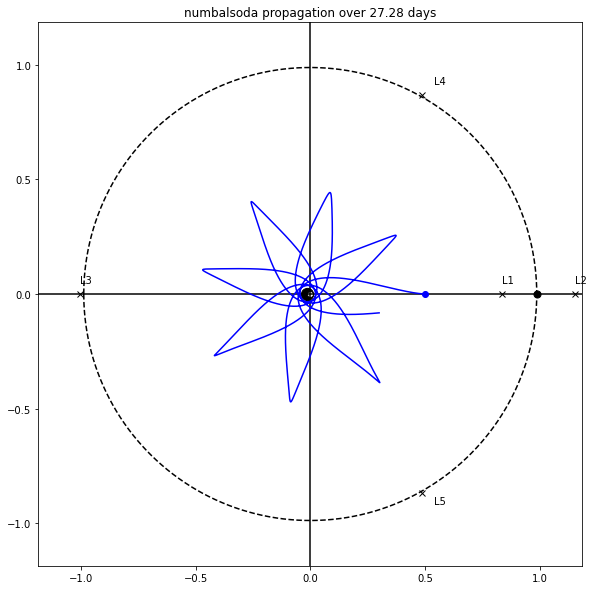

In [7]:
T, X, J = sc.propagate(prop, t_max=2*np.pi, n=1000000)
EM_ax.plot(X[0][0], X[1][0], 'bo') # Initial State
EM_ax.set_title('numbalsoda propagation over %0.2f days'%
                EM.convert(T[-1],to='day').value)
numbalsoda_line = EM_ax.plot(X[0], X[1], 'b')
EM_fig

Now, let's compare this result to another obtained from a different integration method. We will use a Runge-Kutta method, which will be executed with `solve_ivp()`.

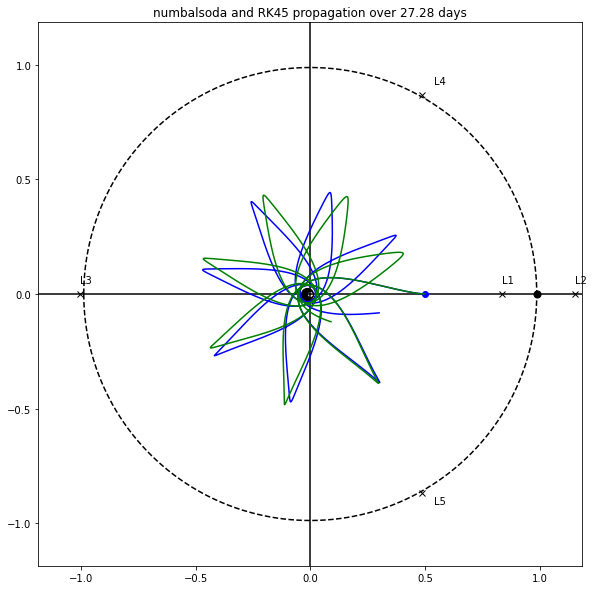

In [9]:
prop2 = Propagator(sc, method='RK45')
T, X2, J2 = sc.propagate(prop2, t_max=2*np.pi)
EM_ax.plot(X2[0][0], X2[1][0], 'g')
EM_ax.set_title('numbalsoda and RK45 propagation over %0.2f days'%
                EM.convert(T[-1],to='day').value)
rk45_line = EM_ax.plot(X2[0], X2[1], 'g')
EM_fig

A large discrepancy between these results is evident. Quantitatively, the results diverge over time, as we can see by plotting the coordinate histories in one dimension:

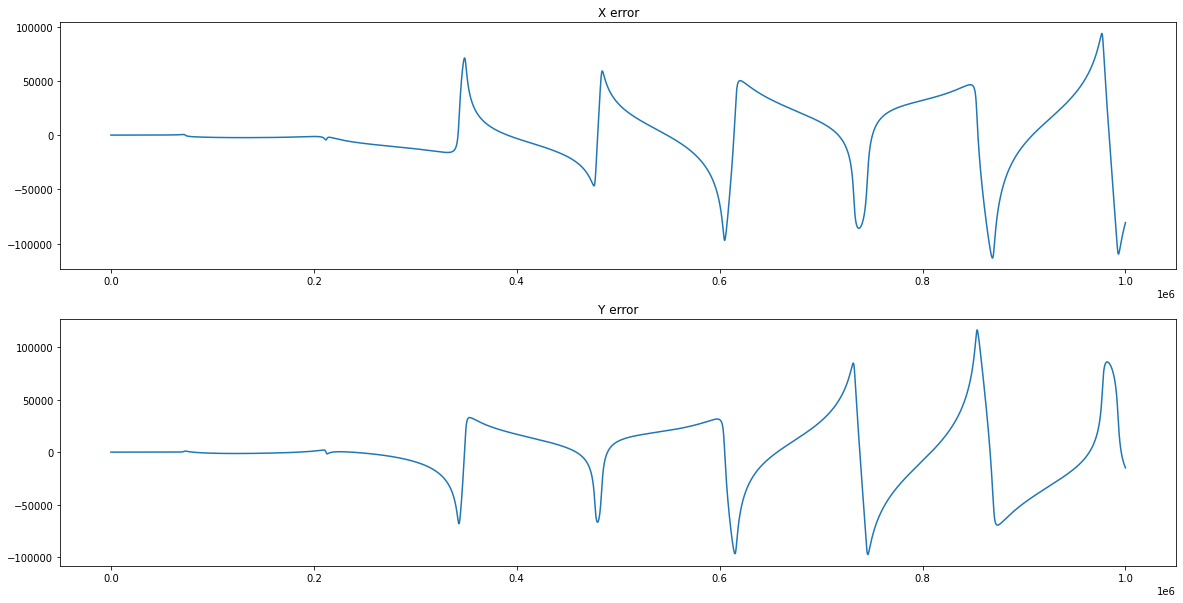

In [10]:
X_km = EM.convert(X, to='km', state_vec=True)
X2_km = EM.convert(X2, to='km', state_vec=True)

fig, axs = plt.subplots(2)
axs[0].plot(X2_km[0]-X_km[0])
axs[0].set_title('X error [km]')
axs[1].plot(X2_km[1]-X_km[1])
axs[1].set_title('Y error [km]');

The reason for this divergence is because we have set the tolerance to be too coarse for the problem. In particular, the fact that the spacecraft routinely comes in close proximity with the Earth is going to cause error accumulation in these numerical methods. 

How do we know this? The evidence is in the time history of the Jacobi constant. As the only integral of motion for the CR3BP, we know that any valid solution for natural motion in these dynamics should have a constant value of `J`, at least to within an acceptable tolerance for our purposes:

Text(0.5, 1.0, 'Jacobi Constant for RK45 integration')

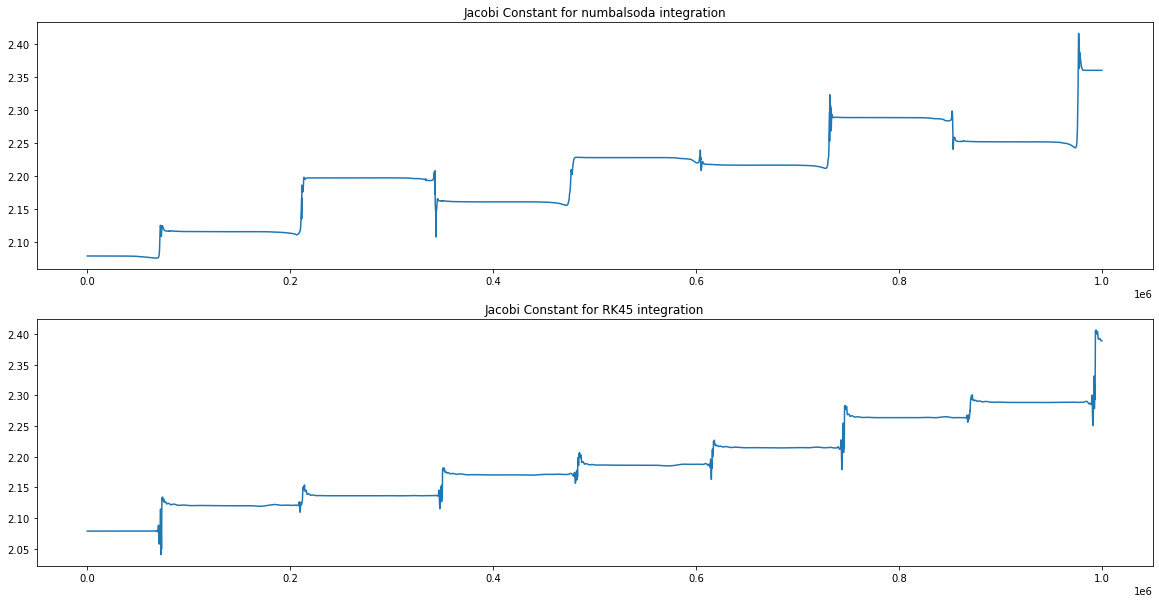

In [11]:
fig, axs = plt.subplots(2)

axs[0].plot(J)
axs[0].set_title('Jacobi Constant for numbalsoda integration')
axs[1].plot(J2)
axs[1].set_title('Jacobi Constant for RK45 integration');

We see marked disturbances in the Jacobi constant each time the spacecraft approaches perigee. This is because the numerical method accumulates error in this part of the orbit where the state is changing rapidly over a comparatively short time, and where certain values (like `1/r1`) are becoming very large.

To address this problem, we will decrease our tolerance for our solvers and compare again:

In [12]:
EM_ax.lines.remove(numbalsoda_line[0])
EM_ax.lines.remove(rk45_line[0])

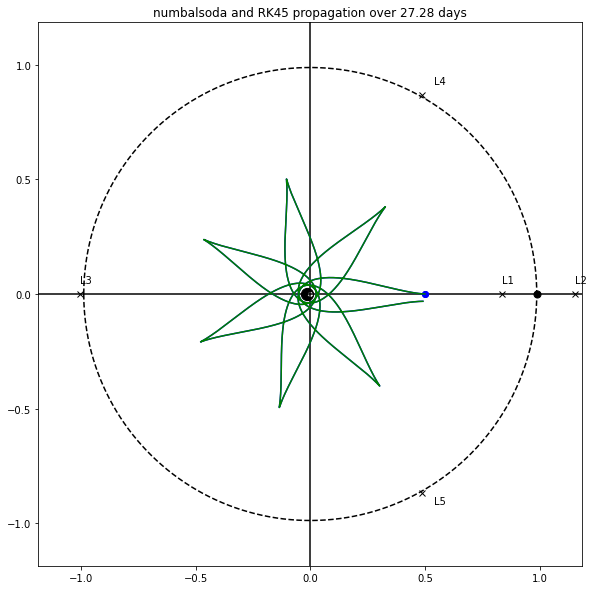

In [13]:
prop = Propagator(sc, method='numbalsoda')
prop.set_tolerance(rtol=1e-9, atol=1e-12)
T, X, J = sc.propagate(prop, t_max=2*np.pi)

prop2 = Propagator(sc, method='RK45')
prop2.set_tolerance(rtol=1e-9, atol=1e-12)
T, X2, J2 = sc.propagate(prop2, t_max=2*np.pi)

EM_ax.plot(X[0][0], X[1][0], 'bo')
numbalsoda_line = EM_ax.plot(X[0], X[1], 'b')
rk45_line = EM_ax.plot(X2[0], X2[1], 'g')
EM_fig

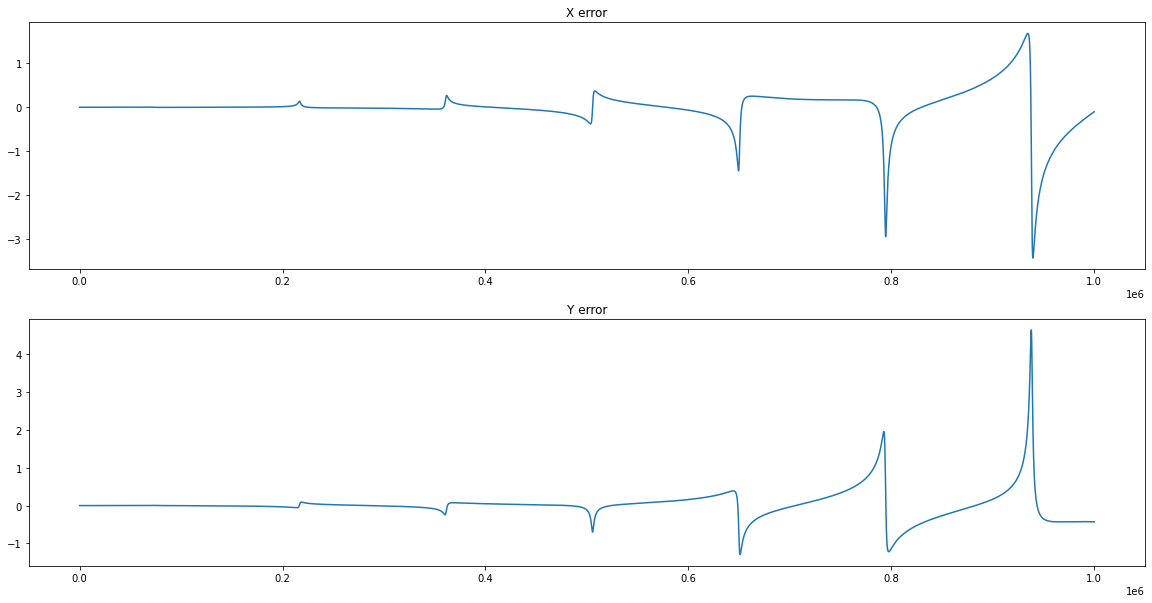

In [14]:
X_km = EM.convert(X, to='km', state_vec=True)
X2_km = EM.convert(X2, to='km', state_vec=True)

fig, axs = plt.subplots(2)
axs[0].plot(X2_km[0]-X_km[0])
axs[0].set_title('X error [km]')
axs[1].plot(X2_km[1]-X_km[1])
axs[1].set_title('Y error [km]');

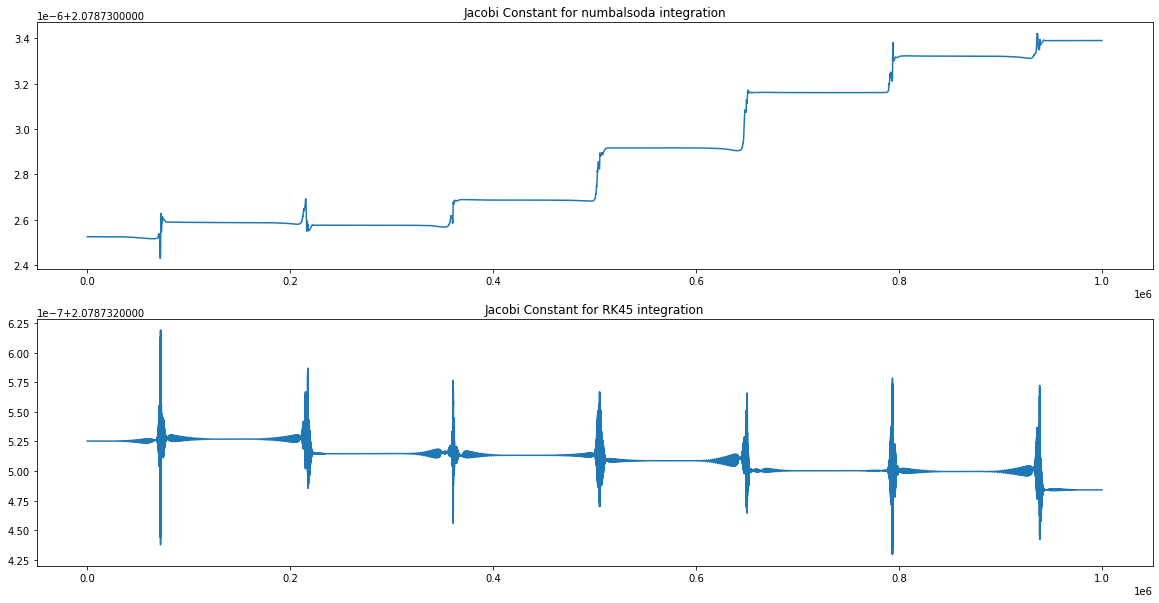

In [16]:
fig, axs = plt.subplots(2)

axs[0].plot(J)
axs[0].set_title('Jacobi Constant for numbalsoda integration')
axs[1].plot(J2)
axs[1].set_title('Jacobi Constant for RK45 integration');

From these results, we see a far more constant value of J for both methods when using finer tolerances, and agreement in the state histories to within a few kilometers over a month. From the plots of their Jacobi constant histories, we can see that the `RK45` method is more constant over time than the `numbalsoda` method. However, this is perhaps the price one pays for speed. 

Using the `timeit` utility, we can compare the speed performance of the propagation (which will depend on this machine's own CPU performance, or that of the MyBinder server hardware assigned to this notebook, if you're viewing from your web browser):

In [51]:
from timeit import timeit

print('\nTime to propagate %0.2f days using the numbalsoda method:'%
      EM.convert(T[-1],to='day').value)
%timeit sc.propagate(prop, t_max=2*np.pi)

print('\nTime to propagate %0.2f days using the RK45 method:'%
      EM.convert(T[-1],to='day').value)
%timeit sc.propagate(prop2, t_max=2*np.pi)


Time to propagate 27.28 days using the numbalsoda method:
152 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Time to propagate 27.28 days using the RK45 method:
507 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Example 3: Finding a Periodic Orbit around L1

To-Do

# Example 4: Implementing a Thrust Profile for the Spacecraft

To-Do

# Example 5: Modeling the Spacecraft as a Solar Sail & Implementing a Controller

To-Do

# Example 6: The Bi-Restricted Four Body Problem - Earth, Moon, and Sun

To-Do

In [ ]:
a_earth = 1.0 * u.au  # km - 1 AU

# Use Poliastro to get body masses: Earth, Moon
# Then instantiate the CR3BP using the Synodic (rotating) Barycentric reference frame
frame = CR3BP(Sun.mass, Earth.mass, a_earth)

mu = frame.mu
xL, yL = frame.xL['L1'], frame.yL['L1']
ac = frame.convert((0.26 * u.mm/(u.s**2)).to('km/s2'))
sc = Spacecraft(frame, ar=ac, at=ac)
sc.set_initial_state([sc.xL_aug-1e-6, 1e-6, 1e-6, 0, 0, 0])
K_xy  = 1
K_z   = 2
db_xy = 0.0003
db_z  = 0.003
sc.set_thrust_profile('sail_control', sc.xL_aug, K_xy, K_z, db_xy, db_z)

# print(sc.controller_params)
prop = Propagator(frame, sc, method='numbalsoda', )


In [ ]:
T, X = prop.integrate(2*np.pi)
plt.plot(X[0],X[1])
plt.show()

In [ ]:
def num_sails(side_length, target_dist, percent_reduction=1.8):
    # Calculate subtended solid angle of the sun from the Earth
    R_sun = Sun.R.to('km').value
    D_sun = (1*u.au).to('km').value
    th_sun = np.arctan2(R_sun,D_sun)*u.rad
    sa_sun = 4*np.pi*np.sin(th_sun/2)**2 * u.sr
    # Calculate subtended solid angle of a single sail from the Earth
    R_sail = side_length.to('m')
    D_sail = target_dist.to('m')
    th_sail = np.arctan2(R_sail,D_sail)
    sa_sail = (th_sail**2).to('sr')
    # Determine number of sails needed to subtend a given amount 
    # (percent_reduction) of the sun's subtended area
    num_sails = int(np.ceil(((percent_reduction/100)/(sa_sail/sa_sun)).value))
    return "{:,} sailcraft".format(num_sails) + \
           " with %0.1f m^2 sail areas"%(side_length.to('m').value**2) + \
           " at a distance of {:,} km would be needed".format(
                np.round(target_dist.to('km').value)) + \
           " for a %0.2f%% reduction in solar irradiance"%(percent_reduction)

In [ ]:
xL_aug_dist = frame.convert((1-frame.mu),to='m') - frame.convert(sc.xL_aug,to='m')
xL_dist = frame.convert((1-frame.mu),to='m') - frame.convert(frame.xL['L1'],to='m')
num_sails(100*u.m, xL_aug_dist)

In [ ]:
num_sails(20*u.m, xL_dist)

In [ ]:
num_sails(20*u.m, xL_dist/3)

In [ ]:
frame2 = CR3BP(Earth.mass, Moon.mass, 384400*u.km)

In [ ]:
frame2.convert(frame2.xL['L2'],to='km')

In [ ]:
x_tgt = ((1-frame.mu) - ((1-frame.mu)-frame.xL['L1'])/0.5).value
print('x_tgt:  ', x_tgt)
print('xL:     ', frame.xL['L1'])
print('xL_aug: ', sc.xL_aug)

In [ ]:
x_tgt=0.99
X0 = [x_tgt+10e-6, -10e-6, 0, 0, 0, 0]
sc.set_initial_state(X0)
K_xy  = 1000
K_z   = 1
db_xy = 0.0001
db_z  = 0.001
sc.set_thrust_profile('sail_control', x_tgt, K_xy, K_z, db_xy, db_z)
T, X = sc.propagate(prop,t_max=2*np.pi, n=1000)

In [ ]:
plt.plot(X[0],X[1])
plt.plot(X[0][0],X[1][0],'ro')
plt.plot(x_tgt,0,'kx')

In [ ]:
ddX = CR3BP_EOM(frame.mu.value, np.array(X0,np.float64))
print(ddX)
print(ac)

In [ ]:
a_x, a_y, a_z, error, beta = sail_control_diagnostic(X, sc.ar, sc.at, x_tgt, K_xy, K_z, db_xy, db_z)
plt.subplot(321)
plt.plot(a_x)
plt.subplot(323)
plt.plot(a_y)
plt.subplot(325)
plt.plot(a_z)

plt.subplot(322)
plt.plot(error)
plt.subplot(324)
plt.plot(beta)
plt.ylim([0,2*np.pi])
plt.yticks([0,3.14,6.28]);

In [ ]:
plt.plot(0.5*np.pi*(1 - np.tanh(1e5*error)))

In [ ]:
periodic